### Email Spam Detection

Jacob Harris \
DASC 5303

#### Project Overview

The data used for this project comes from emails sent to and from employees of the company Enron. This data set was made available to the public and contains over 500,000 emails. This project uses a small subset to give a new method to filter out spam emails based on word counts found in each email.

### Data Overview

The data comes as a .tar.gz compressed file and needs to be unzipped in order to read each .txt file containing the email. In order to do so, a few libraries are needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import os
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.special import iv
from sklearn.linear_model import LogisticRegression

### Data Preprocessing
The following code opens the .tar.gz file and reads each .txt file containing the text from the emails. The spam emails are seperated from the non-spam in the original file and two pandas dataframes are created.

In [2]:
tar_file = '/Users/admin/Desktop/Grad School/DataSciComp/Project/enron1.tar.gz'
extracted_folder = 'extracted_files'  # Folder where files will be extracted

with tarfile.open(tar_file, 'r:gz') as tar:
    tar.extractall(path=extracted_folder)

# Create lists to hold the email data for each folder (ham and spam)
ham_emails = []
spam_emails = []

# Iterate through the extracted files (specifically looking in 'ham' and 'spam' subfolders)
for root, dirs, files in os.walk(os.path.join(extracted_folder, 'enron1')):  # Look inside 'enron1'
    for file in files:
        if file.endswith('.txt'):  # Only process .txt files
            # Get the full path of the file
            file_path = os.path.join(root, file)

            # Check which subfolder this file belongs to ('ham' or 'spam')
            if 'ham' in root:  # If file is in the 'ham' folder
                folder_name = 'ham'
                ham_emails.append(file_path)  # Store the file path for now
            elif 'spam' in root:  # If file is in the 'spam' folder
                folder_name = 'spam'
                spam_emails.append(file_path)  # Store the file path for now

In [3]:
# Read the content of each .txt file and add it to the respective list
ham_email_texts = []
spam_email_texts = []
# Process 'ham' emails
for file_path in ham_emails:
    with open(file_path, 'r', encoding='iso-8859-1') as f:
        email_content = f.read().strip()  # Read and strip any extra spaces/newlines
        ham_email_texts.append(email_content)
# Process 'spam' emails
for file_path in spam_emails:
    with open(file_path, 'r', encoding='iso-8859-1') as f:
        email_content = f.read().strip()  # Read and strip any extra spaces/newlines
        spam_email_texts.append(email_content)

# Create two separate pandas DataFrames for each folder
df_ham = pd.DataFrame(ham_email_texts, columns=['Email_Body'])
df_spam = pd.DataFrame(spam_email_texts, columns=['Email_Body'])

# Check the number of rows in each DataFrame
print(f"Rows in df_ham: {len(df_ham)}")
print(f"Rows in df_spam: {len(df_spam)}")

Rows in df_ham: 3672
Rows in df_spam: 1500


In order to identify spam and non-spam, a new column of 1 or 0 is created for each data frame.

In [4]:
df_ham['Spam_Classification'] = 0
df_spam['Spam_Classification'] = 1
emails = pd.concat([df_ham,df_spam])
emails.iloc[0,0]

"Subject: ena sales on hpl\njust to update you on this project ' s status :\nbased on a new report that scott mills ran for me from sitara , i have come up\nwith the following counterparties as the ones to which ena is selling gas off\nof hpl ' s pipe .\naltrade transaction , l . l . c . gulf gas utilities company\nbrazoria , city of panther pipeline , inc .\ncentral illinois light company praxair , inc .\ncentral power and light company reliant energy - entex\nces - equistar chemicals , lp reliant energy - hl & p\ncorpus christi gas marketing , lp southern union company\nd & h gas company , inc . texas utilities fuel company\nduke energy field services , inc . txu gas distribution\nentex gas marketing company union carbide corporation\nequistar chemicals , lp unit gas transmission company inc .\nsince i ' m not sure exactly what gets entered into sitara , pat clynes\nsuggested that i check with daren farmer to make sure that i ' m not missing\nsomething ( which i did below ) . while i

### Text Processing

In order to use a bag of words approach, the subject line in each email need to be removed and extra characters or punctuation need to be stripped

First, each email is split on a newline character and the first line containing the subject is removed

In [5]:
no_subject_emails = emails['Email_Body'].apply(lambda text: "\n".join(text.split("\n")[1:]))
emails['Email_Body'] = no_subject_emails
emails.head()

,Email_Body,Spam_Classification
0,just to update you on this project ' s status ...,0
1,the above referenced meters need to be placed ...,0
2,( see attached file : hpll 228 . xls )\n- hpll...,0
3,"daren ,\nit ' s in .\nbob\n- - - - - - - - - -...",0
4,"daren ,\nfyi .\nbob\n- - - - - - - - - - - - -...",0


Next, lemmatization is used to group together different forms of the same word. \
Ex: 'emails', 'emailing', and 'email' could all be counted as email \
Stop words ('of', 'a', 'the', etc) are also removed by comparing them to a list given by the 'nltk' library

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/admin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    # Ensure text is a string (this prevents errors)
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()

        # Remove punctuation using regex
        text = re.sub(r'[^a-z\s]', ' ', text)

        # Remove extra spaces (e.g., multiple spaces)
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize the text and remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        
        # Lemmatize each word and remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        # Return the cleaned text (join the tokens into a string)
        return ' '.join(tokens)

In [8]:
clean_messages = emails['Email_Body'].apply(clean_text)
emails['Email_Body'] = clean_messages
emails.iloc[0,0]

'update project status based new report scott mill ran sitara come following counterparties one ena selling gas hpl pipe altrade transaction l l c gulf gas utility company brazoria city panther pipeline inc central illinois light company praxair inc central power light company reliant energy entex ce equistar chemical lp reliant energy hl p corpus christi gas marketing lp southern union company h gas company inc texas utility fuel company duke energy field service inc txu gas distribution entex gas marketing company union carbide corporation equistar chemical lp unit gas transmission company inc since sure exactly get entered sitara pat clynes suggested check daren farmer make sure missing something waiting response mary smith begin gathering contractual volume contract forwarded cheryl dudley hou ect cheryl king pm sent cheryl dudley daren j farmer hou ect ect mary smith hou ect ect cc subject ena sale hpl working project brenda herod wondering one could tell right track get everythin

In [9]:
vectorizer = CountVectorizer()
count_words = vectorizer.fit_transform(emails['Email_Body'])
word_bag = pd.DataFrame(count_words.toarray(), columns=vectorizer.get_feature_names_out())
word_bag.head()

,aa,aaa,aabda,aabvmmq,aac,aachecar,aafco,aaiabe,aaigrcrb,aaihmqv,...,zynsdirnh,zynve,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzn,zzo,zzso,zzsyt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The top 100 words are taken in order to ease computational difficulty and the dataset is combined with the classification from before.

In [10]:
word_counts = word_bag.sum(axis=0)
top_100_words = word_counts.nlargest(100).index
top_100 = word_bag[top_100_words]
rows_with_zeros_100 = top_100.apply(lambda row: (row == 0).all(), axis=1)
top_100.reset_index(drop=True, inplace=True)
emails.reset_index(drop=True, inplace=True)
top_100 = pd.concat([top_100, emails['Spam_Classification']], axis=1)

top_100.head()

,ect,hou,enron,com,deal,please,subject,gas,cc,meter,...,today,td,forward,week,year,inc,delivery,nom,free,Spam_Classification
0,5,3,0,0,5,0,1,9,1,0,...,0,0,0,0,0,5,0,0,0,0
1,0,0,0,0,2,1,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,2,0,0
4,15,8,2,0,3,0,1,3,1,1,...,0,0,0,0,0,1,0,0,0,0


In [11]:
top_100 = top_100[~rows_with_zeros_100]
top_100.shape, sum(top_100['Spam_Classification'])

((4862, 101), 1243)

Next we split into train and test datasets.

In [12]:
train_100, test_100 = train_test_split(top_100,test_size=0.1,random_state=1093)
train_100.shape, train_100['Spam_Classification'].sum(), test_100.shape, test_100['Spam_Classification'].sum()

((4375, 101), 1120, (487, 101), 123)

### Data Analysis

The training data set will be passed to R code in order to fit the Positive von Mises-Fisher distribution to the data. From this, a unit vector will be created and the distance of emails from the test data set will be used to determine if the email is spam or not.

In [13]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [14]:
%load_ext rpy2.ipython

In [15]:
r_train_100 = pandas2ri.py2rpy(train_100)
ro.globalenv['r_train_100'] = r_train_100

#### Positive von Mises-Fisher Distribution

Uses vectors that only contain positive components and whose L2 norm equals 1.

$$\boldsymbol{x} = (x_1, x_2, \dots, x_p) $$

$$||\boldsymbol{x}||_2 = \sqrt{x_1^2+x_2^2+\dots+x_p^2} = 1$$

The density function is given by

$$f(\boldsymbol{x}|\boldsymbol{\mu},\kappa) = \left( \frac{2}{\pi} \right) ^{p/2} \frac{\kappa^{p/2-1}}{I_\nu (\kappa)} \prod_{i=1}^p \cosh(\kappa \mu_i x_i)$$

where $\boldsymbol{\mu}$ is a unit vector with L2 norm of 1, and $\kappa \geq 0$

In order to estimate $\boldsymbol{\mu}$ and $\kappa$, the likelihood of a sample of size $n$ is maximized.

$$L(\boldsymbol{\mu},\kappa|\boldsymbol{x}) = \prod_{i=1}^n f(\boldsymbol{x}_i|\boldsymbol{\mu},\kappa)$$

This results in

$$L(\boldsymbol{\mu},\kappa|\boldsymbol{x}) = \prod_{i=1}^n  \left( \frac{2}{\pi} \right) ^{p/2} \frac{\kappa^{p/2-1}}{I_\nu (\kappa)} \prod_{j=1}^p \cosh(\kappa \mu_j x_{ij})$$

The values of $\hat{\boldsymbol{\mu}}$ and $\hat{\kappa}$ that maximize this function are called the Maximum Likelihood Estimates

In [16]:
%%R
library(rotasym)
library(viridis)
library(rgl)
library(DirStats)

Loading required package: Rcpp
Loading required package: viridisLite


In [17]:
%%R
# softplus approach
f_vmp_sfp <- function(x, mu = c(sqrt(2) / 2, sqrt(2) / 2, rep(0, ncol(x) - 2)),
                      kappa = 1, log = FALSE, x_eps = 11.51) {
  
  # Parameter checks
  x <- rbind(x)
  x <- rotasym::check_unit_norm(x)
  mu <- abs(rotasym::check_unit_norm(mu))
  p <- length(mu)
  
  # x becomes kappa * (x \odot mu)
  x <- t(t(x) * (kappa * mu))
  
  # Log-density
  dens <- rotasym::c_vMF(p = p, kappa = kappa, log = TRUE) +
    rowSums(x) + rowSums(sfp_minus_two(x = x, x_eps = x_eps))
  if (!log) {
    
    dens <- exp(dens)
    
  }
  return(dens)
  
}

# sfp(-2x)
sfp_minus_two <- function(x, x_eps = 11.51) {
  
  sfp_eps <- matrix(0, nrow = nrow(x), ncol = ncol(x))
  ind_eps <- x < x_eps
  sfp_eps[ind_eps] <- log1p(exp(-2 * x[ind_eps]))
  return(sfp_eps)
  
}
# curve(log(sfp_minus_two(rbind(x))), 0, 15)

# A_p(\kappa):=\frac{\mathcal{I}_{p/2}(\kappa)}{\mathcal{I}_{p/2-1}(\kappa)}.
A_p_kappa <- function(kappa, p, deriv = FALSE) {
  
  kappa <- abs(kappa)
  A <- exp(log(besselI(x = kappa, nu = p / 2, expon.scaled = TRUE)) -
             log(besselI(x = kappa, nu = p / 2 - 1, expon.scaled = TRUE)))
  A[kappa == 0] <- 0
  if (deriv) {
    
    A <- 1 - A^2 - ((p - 1) / kappa) * A
    
  }
  return(A)
  
}
# Log-likelihood
minus_log_lik_vmp <- function(x, mu, log_kappa, x_eps = 11.51) {
  
  # Log-likelihood
  kappa <- exp(log_kappa)
  ll <- mean(f_vmp_sfp(x = x, mu = mu, kappa = kappa, log = TRUE,
                       x_eps = x_eps))
  
  # Gradient wrt mu
  n <- nrow(x)
  p <- ncol(x)
  kappa_mu_x <- t(t(x) * (kappa * mu))
  x_mu <- colSums(tanh(kappa_mu_x) * x)
  ll_grad_mu <- drop((kappa * x_mu) %*% (diag(p) - tcrossprod(mu))) / n
  
  # Gradient wrt exp(log_kappa) (that's why the multiplication by kappa)
  ll_grad_kappa <- (-A_p_kappa(kappa = kappa, p = p) +
                      sum(x_mu * mu) / n) * kappa
  
  # Return minus log-likelihood
  attr(ll, "gradient") <- -c(ll_grad_mu, ll_grad_kappa)
  return(-ll)
  
}

# ML estimation - Modified by Jacob Harris
mle_vmp <- function(x, x_eps = 11.51, mu = NULL, kappa = NULL, 
                    known = "none", optfun = "optim", ...) {
  
  # Initial values
  p <- ncol(x)
  mu <- if (is.null(mu)) DirStats::mu_ml(x) else mu
  log_kappa <- if (is.null(kappa)) log(DirStats::kappa_ml(x)) else log(kappa)
  
  # Optimization
  fn <- function(par, known = "none", mu0 = NULL, log_kappa0 = NULL) {
    if (known == "mu"){
      mu <- mu0 / norm(mu0,type='2')
      log_kappa <- par
    } else if (known == 'kappa'){
      mu <- par / norm(par,type='2')
      log_kappa <- log_kappa0
    } else {
      mu <- par[1:p]
      mu <- mu / sqrt(sum(mu^2))
      log_kappa <- par[p + 1]
    }
    ll <- minus_log_lik_vmp(x = x, mu = mu, log_kappa = log_kappa,
                            x_eps = x_eps)
    return(ll)
    
  }
  gr <- function(par, known = "none", mu0 = NULL, log_kappa0 = NULL) {
    if (known == "mu"){
      mu <- mu0 / norm(mu0,type='2')
      log_kappa <- par
      ll <- minus_log_lik_vmp(x = x, mu = mu, log_kappa = log_kappa,
                              x_eps = x_eps)
      return(attr(ll, "gradient")[p+1])
    } else if (known == 'kappa'){
      mu <- par / norm(par,type = '2')
      log_kappa <- log_kappa0
      ll <- minus_log_lik_vmp(x = x, mu = mu, log_kappa = log_kappa,
                              x_eps = x_eps)
      return(attr(ll, "gradient")[1:p])
    } else {
      mu <- par[1:p]
      mu <- mu / sqrt(sum(mu^2))
      log_kappa <- par[p + 1]
      ll <- minus_log_lik_vmp(x = x, mu = mu, log_kappa = log_kappa,
                              x_eps = x_eps)
      return(attr(ll, "gradient"))
    }

    
  }
  if (optfun == "nlm") {
    
    opt <- nlm(p = c(mu, log_kappa), f = fn, ...)
    opt$estimate <- c("mu" = abs(opt$estimate[1:p]) /
                        sqrt(sum(opt$estimate[1:p]^2)),
                      "kappa" = exp(opt$estimate[p + 1]))
    
  } else if (optfun == "optim") {
    
    if (known == "mu"){
      
      opt <- optim(par = log_kappa, fn = fn, gr = gr, method = "BFGS",
                   known = "mu", mu0 = mu, ...)
      opt$par <- c("mu" = mu,
                   "kappa" = exp(opt$par))
      
    } else if (known == "kappa"){
      
      opt <- optim(par = mu, fn = fn, gr = gr, method = "BFGS",
                   known = "kappa", log_kappa0 = log_kappa, ...)
      opt$par <- c("mu" = abs(opt$par[1:p]) / sqrt(sum(opt$par[1:p]^2)),
                   "kappa" = kappa)
      
    } else{
      
      opt <- optim(par = c(mu, log_kappa), fn = fn, gr = gr, method = "BFGS",
                   ...)
      opt$par <- c("mu" = abs(opt$par[1:p]) / sqrt(sum(opt$par[1:p]^2)),
                   "kappa" = exp(opt$par[p + 1]))
    }
    
  } else {
    
    stop("Unknown optimizer")
    
  }
  return(opt)
  
}

In [18]:
%%R
r_train100_1 <- r_train_100[r_train_100$Spam_Classification==1,-101]
r_train100_0 <- r_train_100[r_train_100$Spam_Classification==0,-101]

In [19]:
%%R
r_100_unit1 <- check_unit_norm(r_train100_1)
r_100_unit0 <- check_unit_norm(r_train100_0)

In addition: Warning messages:
1: In check_unit_norm(r_train100_1) :
  r_train100_1 does not have unit-norm rows, normalized internally.
2: In check_unit_norm(r_train100_0) :
  r_train100_0 does not have unit-norm rows, normalized internally.


In [36]:
%%R
rowSums(r_100_unit1**2)[1:5]

4983 3739 3691 3690 4116 
   1    1    1    1    1 


We get the MLEs for the spam and non-spam emails in the training data and pass it back to Python.

In [21]:
%%R
r_spam <- mle_vmp(r_100_unit1)$par
r_spam_vec <- r_spam[-101]
r_non_spam <- mle_vmp(r_100_unit0)$par
r_non_spam_vec <- r_non_spam[-101]

In [22]:
%%R
r_non_spam

        mu.ect         mu.hou       mu.enron         mu.com        mu.deal 
  4.113106e-01   2.184732e-01   4.275755e-01   1.442211e-01   2.970556e-01 
     mu.please     mu.subject         mu.gas          mu.cc       mu.meter 
  2.956925e-01   1.060491e-01   2.266135e-01   9.195835e-04   1.690204e-01 
         mu.pm       mu.daren      mu.thanks        mu.need        mu.corp 
  9.046118e-02   1.301519e-01   1.845595e-01   9.672374e-02   1.737611e-05 
        mu.hpl      mu.volume        mu.know         mu.day       mu.price 
  2.172929e-01   1.210792e-01   1.105065e-01   9.330148e-02   1.710104e-05 
    mu.company       mu.mmbtu         mu.new   mu.forwarded         mu.may 
  3.278280e-05   1.176884e-01   3.719279e-05   4.113648e-05   2.915040e-05 
        mu.get        mu.http         mu.see         mu.let      mu.farmer 
  2.148180e-05   2.665791e-05   1.627203e-01   3.978150e-02   1.794294e-06 
   mu.contract mu.information    mu.attached        mu.time       mu.month 
  2.145260e-

In [23]:
r_spam = ro.r['r_spam']
r_non_spam = ro.r['r_non_spam']
r_spam_mles = ro.r['r_spam_vec']
r_non_spam_mles = ro.r['r_non_spam_vec']
r_spam = ro.conversion.rpy2py(r_spam).reshape(1,-1)
r_non_spam = ro.conversion.rpy2py(r_non_spam).reshape(1,-1)
spam_vector = ro.conversion.rpy2py(r_spam_mles).reshape(1,-1)
non_spam_vector = ro.conversion.rpy2py(r_non_spam_mles).reshape(1,-1)

In [24]:
test_class = test_100['Spam_Classification']
test_vec = test_100.iloc[:, :-1]
norms = np.linalg.norm(test_vec,axis=1)
test_vec = test_vec.div(norms,axis=0)
test_vec.head()

,ect,hou,enron,com,deal,please,subject,gas,cc,meter,...,help,today,td,forward,week,year,inc,delivery,nom,free
357,0.000000,0.000000,0.894427,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1504,0.000000,0.000000,0.392232,0.392232,0.0,0.0,0.196116,0.000000,0.196116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196116,0.000000
4771,0.000000,0.000000,0.000000,0.688247,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1915,0.820553,0.441836,0.000000,0.000000,0.0,0.0,0.063119,0.063119,0.063119,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063119
4537,0.000000,0.000000,0.000000,0.707107,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


### Distances Between Two Points

Two different distances are used to make decisions for the test data set.

Cosine distance: $1 - \frac{u * v}{||u||_2 ||v||_2}$

Minkowski distance: $||u-v||_p$

In this case, $p=1$. The euclidean distance returned the same results as the cosine distance

In [25]:
spam_dist_cos = cdist(test_vec, spam_vector,'cosine')
non_spam_dist_cos = cdist(test_vec, non_spam_vector,'cosine')
spam_dist_minko = cdist(test_vec, spam_vector,'minkowski',p=1.)
non_spam_dist_minko = cdist(test_vec, non_spam_vector,'minkowski',p=1.)
predicted_cos = (spam_dist_cos < non_spam_dist_cos).astype(int)
predicted_minko = (spam_dist_minko < non_spam_dist_minko).astype(int)

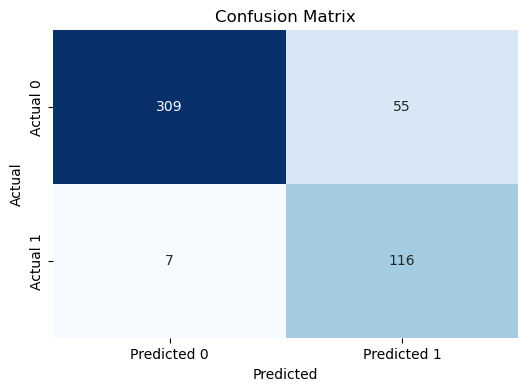

In [26]:
cm_cos = metrics.confusion_matrix(test_class, predicted_cos)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cos, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'],
           cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

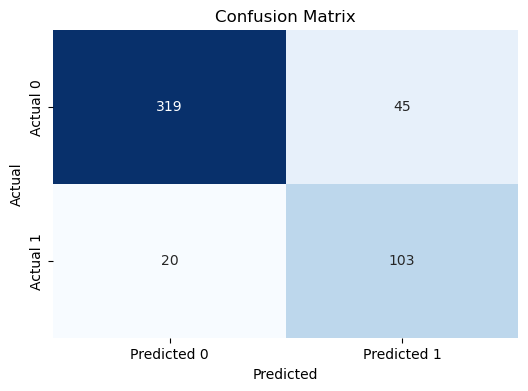

In [27]:
cm_minko = metrics.confusion_matrix(test_class, predicted_minko)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_minko, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'],
           cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We can also use the MLEs from the R output to determine the likelihood of each email in the test data set. The unit vestors corresponding to each email are passed through the Positive von Mises-Fisher distribution twice, the first time with the MLEs found from the spam emails and the second time with the MLEs for the non-spam emails. When comparing the output, the result (or likelihood) with the larger value will determine the classification.

In [28]:
def PvMF(params, df):
    params = np.squeeze(params)
    p = len(df.columns)
    mu = params[:-1]
    kappa = params[-1]

    besseli = iv(p/2 - 1, kappa)
    constant_factor = (2 / np.pi)**(p / 2) * (kappa**(p / 2 - 1)) / besseli

    def row_function(xi):
        product = np.prod(np.cosh(kappa * mu * xi))  # Element-wise multiplication
        return constant_factor * product

    return df.apply(row_function, axis=1)


In [29]:
PvMF_spam = PvMF(r_spam, test_vec)
PvMF_non_spam = PvMF(r_non_spam, test_vec)

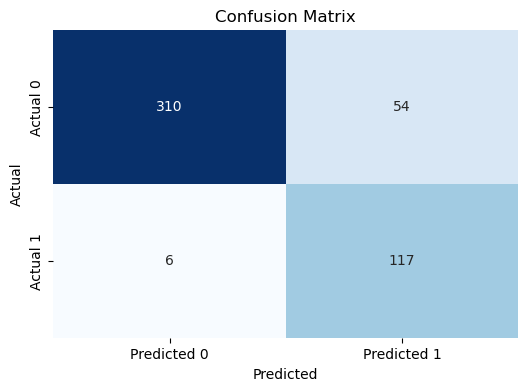

In [30]:
PvMF_pred = (PvMF_spam > PvMF_non_spam).astype(int)
cm_PvMF = metrics.confusion_matrix(test_class, PvMF_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_PvMF, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'],
           cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Metrics

Different metrics can be used to measure the performance of the predicted classes.

Accuracy: $\frac{\mathrm{TP}+\mathrm{TN}}{\mathrm{Total}}$

Precision: $\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}$

Recall: $\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$

In [31]:
cos_metrics = {'Accuracy' : metrics.accuracy_score(test_class,predicted_cos), 
               'Precision' : metrics.precision_score(test_class,predicted_cos),
               'Recall' : metrics.recall_score(test_class,predicted_cos)}
minko_metrics = {'Accuracy' : metrics.accuracy_score(test_class,predicted_minko),
                 'Precision' : metrics.precision_score(test_class,predicted_minko),
                 'Recall' : metrics.recall_score(test_class,predicted_minko)}
PvMF_metrics = {'Accuracy' : metrics.accuracy_score(test_class,PvMF_pred),
                 'Precision' : metrics.precision_score(test_class,PvMF_pred),
                 'Recall' : metrics.recall_score(test_class,PvMF_pred)}
labels = list(cos_metrics.keys())
cos_values = list(cos_metrics.values())
minko_values = list(minko_metrics.values())
PvMF_values = list(PvMF_metrics.values())
index = np.arange(len(labels))

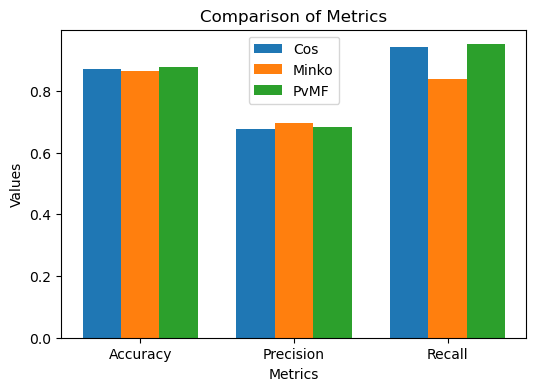

In [32]:
fig, ax = plt.subplots(figsize=(6, 4)) 
bar1 = ax.bar(index, cos_values, 0.25, label="Cos")
bar2 = ax.bar(index + 0.25, minko_values, 0.25, label="Minko")
bar3 = ax.bar(index + 0.5, PvMF_values, 0.25, label="PvMF")
ax.set_xlabel('Metrics'), ax.set_ylabel('Values'), ax.set_title('Comparison of Metrics')
ax.set_xticks(index + 0.5 / 2), ax.set_xticklabels(labels), ax.legend()
plt.show()

#### Logistic Regression

The following code provides a logistic regression model trained on the vector data set. The same metrics will be calculated to compare the performance.

In [33]:
log_model = LogisticRegression()
norms = np.linalg.norm(train_100.iloc[:,:-1],axis=1)
X_train = train_100.iloc[:,:-1].div(norms,axis=0)
Y_train = train_100['Spam_Classification']
log_model.fit(X_train,Y_train)
log_pred = log_model.predict(test_vec)
log_metrics = {'Accuracy' : metrics.accuracy_score(test_class,log_pred), 
               'Precision' : metrics.precision_score(test_class,log_pred),
               'Recall' : metrics.recall_score(test_class,log_pred)}

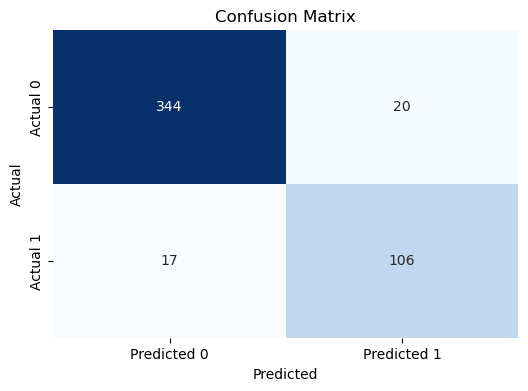

In [34]:
cm_log = metrics.confusion_matrix(test_class, log_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'],
           cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
print("Cosine Metrics:", cos_metrics)
print("L1 Metrics:", minko_metrics)
print("PvMF Metrics:", PvMF_metrics)
print("Logistic Metrics:", log_metrics)

Cosine Metrics: {'Accuracy': 0.8726899383983573, 'Precision': 0.6783625730994152, 'Recall': 0.943089430894309}
L1 Metrics: {'Accuracy': 0.86652977412731, 'Precision': 0.6959459459459459, 'Recall': 0.8373983739837398}
PvMF Metrics: {'Accuracy': 0.8767967145790554, 'Precision': 0.6842105263157895, 'Recall': 0.9512195121951219}
Logistic Metrics: {'Accuracy': 0.9240246406570842, 'Precision': 0.8412698412698413, 'Recall': 0.8617886178861789}


### Conclusion

From the metrics above, the logistic regression model has the best accuracy and precision, with the PvMF likelihood model having the best recall. Depending on the preferred metric, either the logistic regression or the PvMF model would be the best option. It should be noted that the PvMF model does predict a higher number of spam emails than the logistic regression.

The limitations of this project include the fact that the testing data influences the training data. Since the bag of words is implemented before the train/test split, the top 100 words chosen may include words found in the testing data but not the training data. This may lead to different metric scores than what should be seen. This project may also be improved by using cross validation in fitting the models to get a better idea of metric scores based on the training data set. One future improvement to the PvMF likelihood model may include the use of a variable to adjust the ratio of likelihoods. The model implemented looks at whether $L_{\mathrm{spam}}(\boldsymbol{\mu},\kappa|\boldsymbol{x}) > L_{\mathrm{non-spam}}(\boldsymbol{\mu},\kappa|\boldsymbol{x})$ to determine if an email is spam, a future model may use a variable $k$ such that $k*L_{\mathrm{spam}}(\boldsymbol{\mu},\kappa|\boldsymbol{x}) > L_{\mathrm{non-spam}}(\boldsymbol{\mu},\kappa|\boldsymbol{x})$ can be adjusted.